In [1]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)

df = pd.read_sql('SELECT * FROM tlx_info', con=mydb)

user_id_start = 91
df = df[(df.id >= user_id_start) & (df.id != 126)].drop_duplicates()

columns = list(df.columns)
weight_columns = list(df.columns[10:])
load_columns = list(df.columns[4:10])
load_sources = ["Mental", "Physical", "Temporal", "Performance", "Effort", "Frustration"]

df.performance_load = 20-df.performance_load


In [2]:
unweighted_filter = df[df["session"] == 5]
for row in unweighted_filter.values:
    id, software = row[:2]
    weight_values = df[(df.session == 2) & (df.software == software) & (df.id == id)][weight_columns]
    df.loc[((df.session == 5) & (df.software == software) & (df.id == id)), weight_columns] = weight_values.values

In [3]:

df["tlx"] = np.sum(df[load_columns].values*5*df[weight_columns].values, axis=1)/15

nomon_tlx = {}
rowcol_tlx = {}
for session in list(set(df.session.values)):
    nomon_tlx[session] = {"avg": np.average(df[(df.software == "A") & (df.session == session)].tlx.values),
                          "std": np.std(df[(df.software == "A") & (df.session == session)].tlx.values)}
    rowcol_tlx[session] = {"avg": np.average(df[(df.software == "B") & (df.session == session)].tlx.values),
                           "std": np.std(df[(df.software == "B") & (df.session == session)].tlx.values)}

Session  9 :  MannwhitneyuResult(statistic=0.0, pvalue=0.5)
Session  2 :  MannwhitneyuResult(statistic=192.5, pvalue=0.4249020492543943)
Session  10 :  MannwhitneyuResult(statistic=0.0, pvalue=0.5)
Session  5 :  MannwhitneyuResult(statistic=19.0, pvalue=0.41516212882789766)


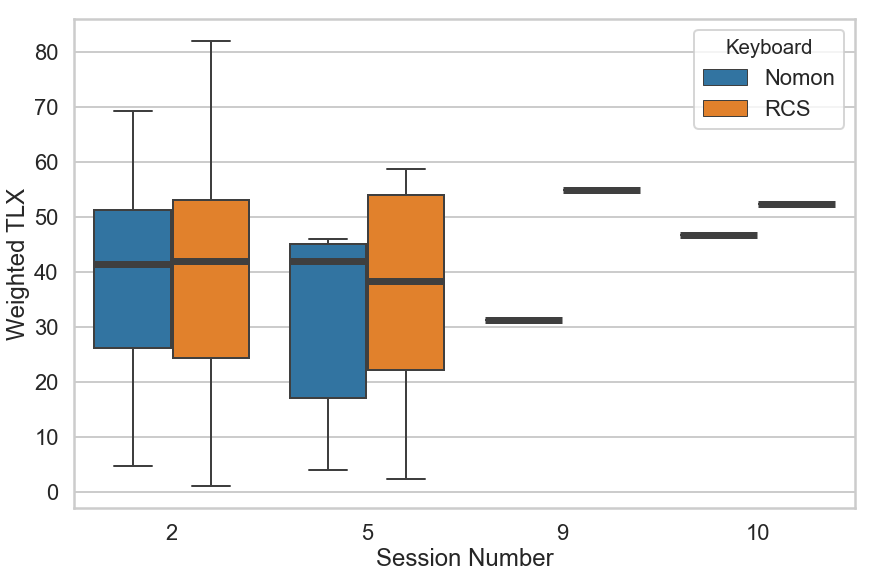

In [4]:
sns.set_context("poster")
sns.set_style("whitegrid")

a4_dims = (14, 9)
fig, ax = plt.subplots(figsize=a4_dims)

tlx_df = df[["tlx", "software", "session"]].rename(columns={"tlx": "Weighted TLX", "software": "Keyboard", "session": "Session Number"})
tlx_df = tlx_df.replace("A", "Nomon")
tlx_df = tlx_df.replace("B", "RCS")

box_plot = sns.boxplot(data=tlx_df, x="Session Number", y="Weighted TLX", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

for session in list(set(df.session.values)):
    print("Session ", session, ": ", stats.mannwhitneyu(
        tlx_df[(tlx_df.Keyboard == "Nomon") & (tlx_df["Session Number"] == session)]["Weighted TLX"].values,
        tlx_df[(tlx_df.Keyboard == "RCS") & (tlx_df["Session Number"] == session)]["Weighted TLX"].values)
          )

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/tlx_1.png")


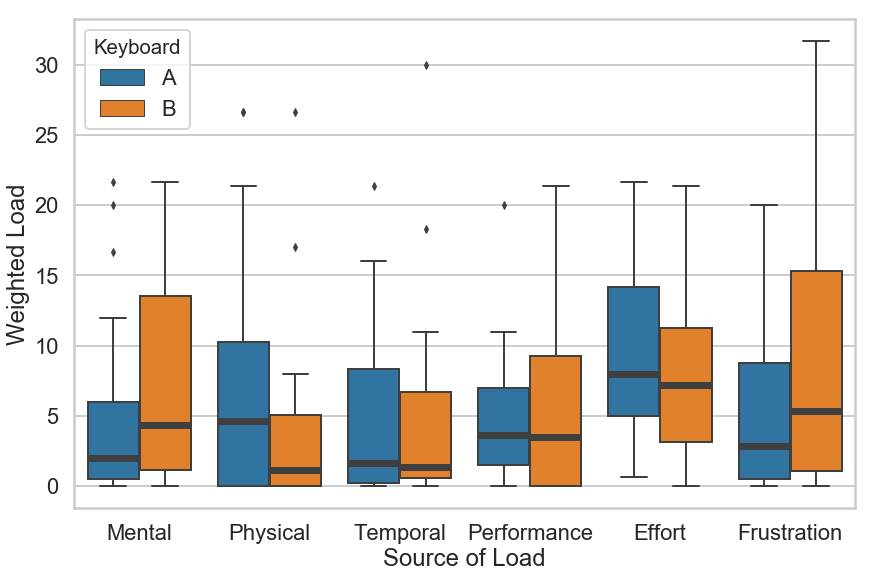

In [5]:
load_df = pd.DataFrame(columns=["Source of Load", "Keyboard", "Weighted Load"])
for row in df[df.session == 2].values:
    for load, weight, source in zip(load_columns, weight_columns, load_sources):
        weight_index = columns.index(weight)  
        load_index = columns.index(load)
        software_index = columns.index("software")
        
        load_df = load_df.append({"Source of Load": source, 
                        "Keyboard": row[software_index], 
                        "Weighted Load": row[load_index]*5*row[weight_index]/15}, ignore_index=True)

a4_dims = (14, 9)
fig, ax = plt.subplots(figsize=a4_dims)

box_plot = sns.boxplot(data=load_df, x="Source of Load", y="Weighted Load", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

